# Illustris TNG
The purpose of this notebook is to connect to the Illustris project and download the data for galaxy clusters in the mass range:
$$10^{13.75}M_{\odot}<M_{500}<10^{15.06}M_{\odot}$$
at z=0 in the Friends-of-Friends group. Then, we will simulate Chandra observations of the clutsers.

In [1]:
%matplotlib inline
from additionalfunctions import utherm_ne_to_temp, solar_met, update_progress
import requests
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yt
from yt.utilities.cosmology import Cosmology
import pyxsim
import os
import shutil
import soxs

soxs : [WARNING  ] 2021-11-04 17:10:15,034 Setting 'soxs_data_dir' to /home/msadikov/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


## Step 1: Download subhalos from Illustris TNG 
If you have already downloaded the subhalos, you can skip this step and move directly to step 2!

In [2]:
print(pyxsim.__version__)

3.0.1


In [11]:
output_dir = 'TNG300/Clusters'  # Directory where the cluster ICM information will be stored
snapshot_id = 99  # ID of snapshot

# Make sure the output directory exists. If not, create it
#if not os.path.exists('%s/snapshot_%i/'%(output_dir, snapshot_id)):
#    os.mkdir('%s/snapshot_%i/'%(output_dir, snapshot_id))

In [12]:
#Basic setup taken from Illustris TNG wiki with my personal api-key

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"df26a8d0d3e4ec231734b077b81291cb"}

def get(path, params=None, output_dir_cutout='Clusters'):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(output_dir_cutout+'/'+filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r
r = get(baseUrl)

In [13]:
# first convert log solar masses into group catalog units
mass_min = 10**13.75 / 1e10 * 0.704
mass_max = 10**15.06 / 1e10 * 0.704
print(mass_min,mass_max)
# form the search_query string by hand for once
search_query = "?limit=700&mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)


3958.8829293400577 80830.01495338063


How many clusters (subhalos) are within this range in the z=0 snapshot of TNG 300?

In [14]:
url = "http://www.tng-project.org/api/TNG300-1/snapshots/z=0/subhalos/" + search_query
subhalos = get(url)
ids = [subhalos['results'][i]['id'] for i in range(len(subhalos['results'])) ]
num_subhalos = subhalos['count']
print("There are %i clusters in the z=0 snapshot of TNG 300."%num_subhalos)
# Now let's save this list in a txt file
#with open('snapshot%i_clusters.txt'%snapshot_id, 'w+') as f_out:
#    f_out.write('# List of subhalo IDS corresponding to clusters with log masses between 13.75 and 15.06\n')
#    for id_ in ids:
#        f_out.write('%i\n'%id_)

There are 686 clusters in the z=0 snapshot of TNG 300.


Let's take a quick lok at what these look like. You will see that it has the subhalo ID, the SFR, the log of the mass, and the URL to the subhalo.

In [7]:
print(len(subhalos['results']))
subhalos['results'][:2]

686


[{'id': 1,
  'sfr': 0.0,
  'mass_log_msun': 14.729459652476862,
  'url': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/1/'},
 {'id': 17908,
  'sfr': 6.94472,
  'mass_log_msun': 15.042908906181673,
  'url': 'http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/17908/'}]

Now that we have our list of subhalos, we can go ahead and loop through each and save their cutouts. We don't need to save all of their information though! Instead we just need the parameters relevant to the X-ray emission

In [ ]:
base_url = "http://www.tng-project.org/api/TNG300-1/"
sim_metadata = get(base_url)
#num_subhalos = 2
update_progress(0)
nhalo=1
for id_ in ids[:num_subhalos]:
    snapshot_url = "http://www.tng-project.org/api/TNG300-1/snapshots/z=0/subhalos/" + str(id_) + "/cutout.hdf5"
    saved_filename = get(snapshot_url, params={"gas":"all"}, output_dir_cutout='%s/snapshot_%i/'%(output_dir, snapshot_id))
    update_progress(nhalo / num_subhalos)
    nhalo+=1


### Quick Detour: Visualization
Let's visualize how one of these clutsers look

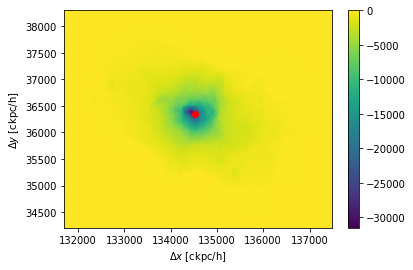

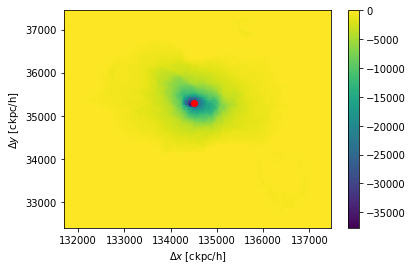

In [4]:
j=37492
j=27878
with h5py.File('/home/msadikov/Documents/TNG300/Clusters/snapshot_99/cutout_%i.hdf5'%(j),'r') as f:
    x = f['PartType0']['Coordinates'][:,0]
    y = f['PartType0']['Coordinates'][:,1]
    z = f['PartType0']['Coordinates'][:,2]
    dens = np.log10(f['PartType0']['Density'][:])
    density = f['PartType0']['Density'][:]


from scipy.ndimage import center_of_mass

#construct a histogram from separate one-dim arrays
xyz = np.array([x,y,z])
H, edges= np.histogramdd(np.transpose(xyz), weights = density, bins=300)
xedg, yedg, zedg = edges[0], edges[1], edges[2]

#width of the bins in each dimension
x_bin = np.mean(np.abs(np.diff(xedg)))
y_bin = np.mean(np.abs(np.diff(yedg)))
z_bin = np.mean(np.abs(np.diff(zedg)))

#get coordinates of center on mass (in relation to the array elements)
C = center_of_mass(H)

#get the actual coordinates in physical distances
x0, y0, z0= C[0]*x_bin+xedg[0], C[1]*y_bin+yedg[0], C[2]*z_bin+zedg[0]
plt.hist2d(x,y,weights=dens,bins=[300,300])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]')
plt.plot(x0, y0,'r', marker='o')
plt.colorbar()
#plt.savefig('/home/msadikov/Documents/images/cluster_{}_logdens.png'.format(j))
plt.show()
plt.hist2d(x,z,weights=dens,bins=[300,300])
plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta z$ [ckpc/h]')
plt.plot(x0, z0,'r', marker='o')
plt.colorbar()
plt.show()



In [ ]:
print(x[2])

What are all the parameters that we have in the file?

In [58]:
np.shape(xy_edges)

(2, 301)

In [9]:
with h5py.File('/home/msadikov/Documents/TNG300/Clusters/snapshot_99/cutout_%i.hdf5'%(j),'r') as f:
    for name in f['PartType0']:
        print(name)

CenterOfMass
Coordinates
Density
ElectronAbundance
EnergyDissipation
GFM_AGNRadiation
GFM_CoolingRate
GFM_Metallicity
GFM_Metals
GFM_MetalsTagged
GFM_WindDMVelDisp
GFM_WindHostHaloMass
InternalEnergy
Machnumber
MagneticField
MagneticFieldDivergence
Masses
NeutralHydrogenAbundance
ParticleIDs
Potential
StarFormationRate
SubfindDMDensity
SubfindDensity
SubfindHsml
SubfindVelDisp
Velocities


In [15]:
def get_t_cool(j):
    #j = cluster_id
    with h5py.File('/home/msadikov/Documents/TNG300/Clusters/snapshot_99/cutout_%i.hdf5'%(j),'r') as f:
        gas = f['PartType0']
        density = gas['Density'][:]
        x = gas['Coordinates'][:,0]
        y = gas['Coordinates'][:,1]
        z = gas['Coordinates'][:,2]
        
        #construct a histogram from separate one-dim arrays
        xyz = np.array([x,y,z])
        H, edges= np.histogramdd(np.transpose(xyz), weights = density, bins=300)
        xedg, yedg, zedg = edges[0], edges[1], edges[2]

        #width of the bins in each dimension
        x_bin = np.mean(np.abs(np.diff(xedg)))
        y_bin = np.mean(np.abs(np.diff(yedg)))
        z_bin = np.mean(np.abs(np.diff(zedg)))

        #get coordinates of center on mass (in relation to the array elements)
        C = center_of_mass(H)

        #get the actual coordinates in physical distances
        x0, y0, z0= C[0]*x_bin+xedg[0], C[1]*y_bin+yedg[0], C[2]*z_bin+zedg[0]
        
        
        r = np.sqrt((x-x0)**2+(y-y0)**2+(z-z0)**2)
        X_H = 0.76 #approximate hydrogen mass fraction
        m_p = 8.4089e-68 #proton mass in 1e10 solar masses
        h = 0.68
        kpc_to_cm = 3.086e21
        n_e =(gas['ElectronAbundance'][:]*X_H*density*h**2)/(m_p*kpc_to_cm**3) #in cm^-3
        temperature = utherm_ne_to_temp(gas['InternalEnergy'][:],gas['ElectronAbundance'][:]) #in K
    
        #we divide the sphere of gas in iax spherical shells of thickness a
        a=5
        imax = int(np.ceil(np.max(r)/a))
        mean_density_tab = np.zeros(imax)
    
        for i in range(imax):
            idx_i=np.argwhere((r>=i*a)&(r<(i+1)*a))
            mean_dens_i = np.mean(density[idx_i])
            mean_density_tab[i] = mean_dens_i
            if np.isnan(mean_dens_i)==True:
                mean_density_tab[i]=mean_density_tab[i-1]
          
        #find R_500
        rho_c = 27.754e-9 #in 10^10 M_sun*h^2 / kpc^3
    
        diff = np.abs(mean_density_tab-500*rho_c)
        density_500 = mean_density_tab[np.argmin(diff)]
        R_500 = (np.argmin(diff)+1)*a
        print('R_500=', R_500)
        
        
        idx_int = np.argwhere(r<R_500)
        n_e_mean = np.mean(n_e[idx_int])
        temp_mean = np.mean(temperature[idx_int])
    
        if temp_mean >= 3e7:
            t_cool = 3.2e10 * (1e-3/n_e_mean) * (temp_mean/1e7)**0.5 #in yr
        elif temp_mean < 3e7:
            t_cool = 0.8e10 * (1e-3/n_e_mean) * (temp_mean/1e7)**1.6 #in yr
        
        print('t_cool=',t_cool/1e9, 'Gyrs')
        if t_cool<1e9:
            print('cool core')
        else:
            print('non-cool core')        
        
        
        plt.figure(figsize=(17,4))
        plt.subplots_adjust(wspace=0.35)
        plt.subplot(1,3,1)
        plt.hist2d(x,y,weights=density,bins=[300,300])
        plt.xlabel('$\Delta x$ [ckpc/h]')
        plt.ylabel('$\Delta y$ [ckpc/h]')

        plt.subplot(1,3,2)
        plt.hist2d(x,y,weights=np.log10(density),bins=[300,300])
        plt.xlabel('$\Delta x$ [ckpc/h]')
        plt.ylabel('$\Delta y$ [ckpc/h]')   
        plt.scatter(x0, y0, color='r', marker='+')
        plt.title('t_cool = {:.4f} Gyrs'.format(t_cool/1e9))
    
        plt.subplot(1,3,3)
        plt.xlabel('r [ckpc/h]')
        plt.ylabel('Density [ $10^{10}M_{\odot}h^2/ckpc^3$]')
        plt.plot(np.arange(0, imax*a,a), mean_density_tab)
        plt.axvline(R_500, label = 'R_500',linestyle='-',color='r')
        plt.legend()
        plt.savefig('/home/msadikov/Documents/images/t_cool_images/t_cool_image_{}.png'.format(j))
        plt.show()
    
    

        return t_cool

/home/msadikov/anaconda3/envs/astro/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/msadikov/anaconda3/envs/astro/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


R_500= 165
t_cool= 29.468226082813754 Gyrs
non-cool core


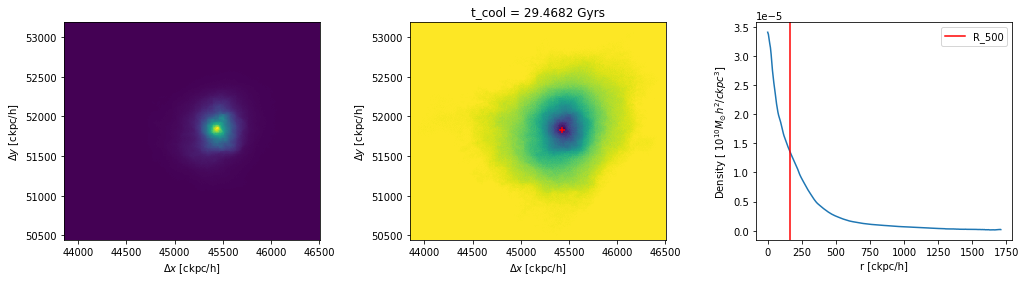

In [9]:
t_cool_1 = get_t_cool(1)


While these are all very interesting properties, we do need need all of these! Let's go ahead and make some pickle files containing the information that we  need for each cluster!

In [16]:
#t_cool_tab = np.zeros((num_subhalos,2))
update_progress(0)
for i, id_ in enumerate(ids[:15]):
    t_cool = get_t_cool(id_)
    #t_cool_tab[i,0], t_cool_tab[i,1]=id_, t_cool
    update_progress(i/15)

Progress: [###################-] 93.3%


In [ ]:
'''
ct = 0
#update_progress(0)
ids=[17908]
#for id_ in ids[:num_subhalos]:  # Step through all clusters
for id_ in ids:
# Get the values we want
    with h5py.File('%s/snapshot_%i/cutout_%i.hdf5'%(output_dir,snapshot_id,id_),'r') as f:
        gas = f['PartType0']
        x = gas['Coordinates'][:,0]
        y = gas['Coordinates'][:,1]
        z = gas['Coordinates'][:,2]
        velx = gas['Velocities'][:,0]
        vely = gas['Velocities'][:,1]
        velz = gas['Velocities'][:,2]
        particle_mass = gas['Masses'][:]
        metallicity = solar_met(gas['GFM_Metallicity'][:])
        density = gas['Density'][:]
        density_sq = gas['Density'][:].T*gas['Density'][:]
        temp = utherm_ne_to_temp(gas['InternalEnergy'][:],gas['ElectronAbundance'][:])
        ElectronAbundance = gas['ElectronAbundance'][:]
        NeutralHydrogenAbundance = gas['NeutralHydrogenAbundance'][:]
        # Put in appropriate YT form
        cluster = {"x":x, "y":y, "z":z,
            'particle_position_x': (x, "kpc"),
            'particle_position_y': (y, "kpc"),
            'particle_position_z': (z, "kpc"),
            'particle_velocity_x': (velx*10000.0, "cm/s"),
            'particle_velocity_y': (vely*10000.0, "cm/s"),
            'particle_velocity_z': (velz*10000.0, "cm/s"),
            'density_sq' : density_sq,
            'temperature': temp,
            'metallicity': metallicity,
            'particle_mass': particle_mass,
            'density': density,
            'ElectronAbundance': ElectronAbundance,
            'NeutralHydrogenAbundance': NeutralHydrogenAbundance}
        # Assign to cluster dictionary
        #cluster = {"x":x, "y":y, "z":z, "mass":particle_mass, "metallicity":metallicity, "density":density, "density_sq":density_sq,
                   #"temp":temp, "ElectronAbundance":ElectronAbundance, "NeutralHydrogenAbundance":NeutralHydrogenAbundance,
                   #"velx":velx, "vely":vely, "velz":velz}
        # Save to pickle file
        pickle.dump(cluster, open('%s/snapshot_%i/cluster_%i.pkl'%(output_dir,snapshot_id, id_), 'wb'))
        #update_progress(id_ / num_subhalos)
        '''

In [ ]:
import pyxsim
print(pyxsim.__version__)

In [ ]:
import os

## Step 2: Create photon event files
In this step we will use pyxsim to create photon event files from our clusters


In [12]:
if not os.getcwd().endswith(str(snapshot_id)):
    os.chdir("%s/%s/snapshot_%i"%(os.getcwd(), output_dir,snapshot_id))
time_unit = yt.YTQuantity(1.0e-5, "kpc*s/cm").to("s")
velocity_unit = yt.YTQuantity(1.0e5, "cm/s")
#update_progress(0)
#nhalo=1


for id_ in ids[:1]:  # Step through all clusters
    #ds = yt.load('cutout_%i.hdf5'%(id_))
    #cluster_pickle = pickle.load(open('cluster_%i.pkl'%(id_),'rb'))
    #bbox = np.array([[min(cluster_pickle['x']), max(cluster_pickle['x'])], 
                     #[min(cluster_pickle['y']), max(cluster_pickle['y'])], 
                     #[min(cluster_pickle['z']), max(cluster_pickle['z'])]])
    ds = yt.load('cutout_%i.hdf5'%id_)#_particles(cluster_pickle, length_unit="kpc", mass_unit=yt.YTQuantity(1e10, "Msun"), time_unit=time_unit, 
                           #velocity_unit=velocity_unit, bbox=bbox, default_species_fields='ionized')
    #ds.add_sph_fields()
    #sp = ds.sphere("c", (500.0, "kpc"))
    sp = ds.all_data()
    redshift = 0.05 # The redshift to the object.
    area = (1000., "cm**2") # A constant effective area to generate the photons with.
    exp_time = (300., "ks") # The exposure time to generate the photons with.
    # Optionally, construct a cosmology object.
    cosmo = Cosmology(hubble_constant=0.68, omega_matter=0.31, omega_lambda=0.69)
    #Set source thermal model
    source_model = pyxsim.ThermalSourceModel("apec", 0.05, 11.0, 1000,
                                              Zmet=('gas','metallicity'),
                                              #emission_measure_field=('gas','particle_mass'),
                                              temperature_field=('gas','temperature'))
    #Create photon list
    n_photons, n_cells = pyxsim.make_photons("cluster_photons_%i"%id_, sp, redshift, area, exp_time, source_model, cosmology=cosmo)
    n_events = pyxsim.project_photons("cluster_photons_%i"%id_, "cluster_events_%i"%id_, "z", (45.,30.))#, absorb_model="tbabs", nH=0.04)
    # Write out 
    events = pyxsim.EventList("cluster_events_%i.h5"%id_)
    events.write_to_simput("cluster_%i"%id_, overwrite=True)
    #update_progress(nhalo / num_subhalos)
    #nhalo+=1
    

yt : [INFO     ] 2021-10-28 12:11:40,818 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2021-10-28 12:11:40,866 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2021-10-28 12:11:40,866 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-10-28 12:11:40,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-10-28 12:11:40,867 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2021-10-28 12:11:40,867 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-10-28 12:11:40,868 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2021-10-28 12:11:40,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2021-10-28 12:11:40,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2021-10-28 12:11:40,869 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-10-28 12:11:40,869 Parameters: hubble_con

Preparing spectrum table :   0%|          | 0/201 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/6308389 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2021-10-28 12:13:23,851 Finished generating photons.
pyxsim : [INFO     ] 2021-10-28 12:13:23,851 Number of photons generated: 77882764
pyxsim : [INFO     ] 2021-10-28 12:13:23,852 Number of cells with photons: 6090374
pyxsim : [INFO     ] 2021-10-28 12:13:23,853 Foreground galactic absorption: using the wabs model and nH = 0.04.
Projecting photons from cells/particles: 100%|█| 6090374/6090374 [00:25<00:00, 2
pyxsim : [INFO     ] 2021-10-28 12:13:50,777 Detected 27359678 events.
soxs : [WARNING  ] 2021-10-28 12:13:57,136 Overwriting cluster_1_phlist.fits.
soxs : [INFO     ] 2021-10-28 12:13:57,624 Writing source to cluster_1_phlist.fits.


## Step 3:
Now that we have our photons corresponding to each cluster, we can convolve them through our favorite instrumental response

soxs : [INFO     ] 2021-10-28 12:14:09,946 Making observation of source in cluster_1_evt.fits.
soxs : [INFO     ] 2021-10-28 12:14:10,182 Detecting events from source cluster_1
soxs : [INFO     ] 2021-10-28 12:14:10,182 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2021-10-28 12:14:11,801 7275482 events detected.
soxs : [INFO     ] 2021-10-28 12:14:11,999 Pixeling events.
soxs : [INFO     ] 2021-10-28 12:14:13,159 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2021-10-28 12:14:15,337 7275482 events were rejected because they do not fall on any CCD.
soxs : [WARNING  ] 2021-10-28 12:14:15,342 No events are within the field of view for this source!!!
soxs : [WARNING  ] 2021-10-28 12:14:15,342 No events from any of the sources in the catalog were detected!
soxs : [INFO     ] 2021-10-28 12:14:15,347 Adding background events.
soxs : [INFO     ] 2021-10-28 12:14:15,372 Adding in point-source background.
soxs : [INFO     ] 2021-10-28 

Scattering energies :   0%|          | 0/32178 [00:00<?, ?it/s]

soxs : [INFO     ] 2021-10-28 12:14:16,269 Generated 32178 photons from the point-source background.
soxs : [INFO     ] 2021-10-28 12:14:16,269 Adding in astrophysical foreground.
soxs : [INFO     ] 2021-10-28 12:14:16,273 Making 12729 events from the astrophysical foreground.
soxs : [INFO     ] 2021-10-28 12:14:16,274 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/12729 [00:00<?, ?it/s]

soxs : [INFO     ] 2021-10-28 12:14:16,359 Adding in instrumental background.
soxs : [INFO     ] 2021-10-28 12:14:16,396 Making 364379 events from the instrumental background.
soxs : [INFO     ] 2021-10-28 12:14:16,421 Writing events to file cluster_1_evt.fits.
soxs : [INFO     ] 2021-10-28 12:14:17,316 Observation complete.


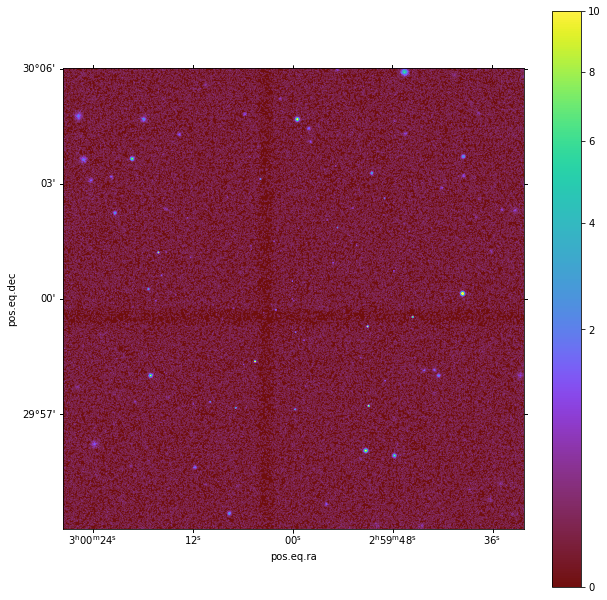

In [13]:
#update_progress(0)
#nhalo=1
#for id_ in ids[:num_subhalos]:  # Step through all clusters

for id_ in ids[:1]:    
    soxs.instrument_simulator("cluster_%i_simput.fits"%id_, "cluster_%i_evt.fits"%id_, (300.0, "ks"), "chandra_acisi_cy0",
                          [45., 30.], overwrite=True)
    # Turn event file into image
    soxs.write_image("cluster_%i_evt.fits"%id_, "cluster_%i_img.fits"%id_, emin=0.1, emax=8.0, overwrite=True)
    # Plot out 
    soxs.plot_image("cluster_%i_img.fits"%id_, stretch='sqrt', cmap='arbre', vmin=0.0, vmax=10.0, width=0.2)
    #update_progress(nhalo / num_subhalos)
    #nhalo+=1
